In [1]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv
import json
import shutil
from PIL import Image
from scipy.optimize import direct

from ultralytics import YOLO
import yaml
import random

In [2]:
CWD = os.getcwd()
DATA_DIR = "yolodata"
IMAGES_TRAIN = os.path.join(CWD, "resources", DATA_DIR, "images", "train")
IMAGES_TEST = os.path.join(CWD, "resources", DATA_DIR, "images", "test")
LABELS_TRAIN = os.path.join(CWD, "resources", DATA_DIR, "raw-labels", "train")
LABELS_TEST = os.path.join(CWD, "resources", DATA_DIR, "raw-labels", "test")
#SEGMENTED_TRAIN = os.path.join(CWD, "resources", DATA_DIR, "segmented", "color_labels", "train")
#SEGMENTED_VAL = os.path.join(CWD, "resources", DATA_DIR, "segmented", "color_labels", "val")

In [3]:
ENCLABELS_TRAIN = os.path.join(CWD, "resources", DATA_DIR, "labels", "train")
ENCLABELS_TEST = os.path.join(CWD, "resources", DATA_DIR, "labels", "test")

In [39]:
# just change what these vars below equal to pull from diff sources
train_images_paths = sorted(os.listdir(IMAGES_TRAIN))
test_images_paths = sorted(os.listdir(IMAGES_TEST))

train_labels_paths = sorted(os.listdir(LABELS_TRAIN))
test_labels_paths = sorted(os.listdir(LABELS_TEST))

#seg_train_images_paths = sorted(os.listdir(BDD_SEGMENTED_TRAIN))
#seg_test_images_paths = sorted(os.listdir(BDD_SEGMENTED_VAL))

In [40]:
print(train_images_paths[0:10], train_labels_paths[0:10])
print(len(train_images_paths),len(test_images_paths))
print(len(train_labels_paths),len(test_labels_paths))
#print(len(seg_train_images_paths),seg_train_images_paths[0])

['0000f77c-cb820c98.jpg', '00091078-f32de4d2.jpg', '00390995-49d9a01e.jpg', '004071a4-ef4bf541.jpg', '005ff190-5be4cdfa.jpg', '0060b445-5acc00ed.jpg', '00618cec-a7f7e470.jpg', '0062f18d-f8cd3a65.jpg', '0065fe83-c80cf6c3.jpg', '008edf63-51af8ab6.jpg'] ['0000f77c-cb820c98.json', '00091078-f32de4d2.json', '00390995-49d9a01e.json', '004071a4-ef4bf541.json', '005ff190-5be4cdfa.json', '0060b445-5acc00ed.json', '00618cec-a7f7e470.json', '0062f18d-f8cd3a65.json', '0065fe83-c80cf6c3.json', '008edf63-51af8ab6.json']
4000 2000
4000 2000


## Load Images
Use Pillow cuz its easy, json.load()
Populate arrays containing image data and label data

In [41]:
#Load images based on a source directory where it comes from and the actual image
def load_images(images_dir,images_paths):
    images=[]
    for i in range(len(images_paths)):
        try:
            path = os.path.join(images_dir,images_paths[i])
            img = Image.open(path)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {images_paths[i]}: {e}")
    return np.array(images)

In [42]:
#Load labels based on a source directory where it comes from and the actual label
def load_labels(labels_dir,labels_paths):
    labels=[]
    for i in range(len(labels_paths)):
        with open(os.path.join(labels_dir,labels_paths[i]),"r") as file:
            parsed = json.load(file)
            labels.append(parsed)
    return labels

In [43]:
train_images = load_images(IMAGES_TRAIN, train_images_paths)
test_images = load_images(IMAGES_TEST, test_images_paths)
train_labels = load_labels(LABELS_TRAIN, train_labels_paths)
test_labels = load_labels(LABELS_TEST, test_labels_paths)

581.938239
(720, 1280, 3)
4000


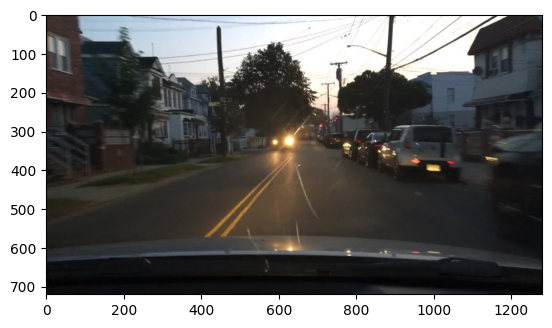

In [44]:
#testing out our data

#print(train_images[0])
print(train_labels[0]["frames"][0]["objects"][0]["box2d"]["x1"])
#get set of objects: train_labels[0]["frames"][0]["objects"]
#each object: object["attributes"]["box2d"]["x1"|"x2"|"y1"|"y2"]

print(train_images[0].shape)
print(len(train_images))


# BUG WITH IMSHOW: THE EDITOR INVERTS THE COLORS SO YEAH USE SAVEFIG
plt.imshow(train_images[0])
plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Work with images loaded

In [45]:
def get_object_area(ob):
    pt1,pt2=get_box_from_object(ob)
    return (pt2[0]-pt1[0]) * (pt2[1]-pt1[1])

def get_box_from_object(object):
    """
    for a labeled object for an image, find its bounding box
    :param object: object from label
    :return: 4 coordinates: x1, y1,  x2, y2
    """
    return (object["box2d"]["x1"],object["box2d"]["y1"]),(object["box2d"]["x2"],object["box2d"]["y2"])

def get_objects(label):
    """
    For a label json object containing json data labeling an image, find labeled objects
    Note: some objects include drivable roadways: remove those
    :param label: json object containing data
    :return: labeled objects in image
    """
    all_objs = label["frames"][0]["objects"]
    objs=[]
    areas = []
    banned_objs = ["traffic sign", "traffic light", "rider"]
    for ob in all_objs:
        if "box2d" in ob and ob["category"] not in banned_objs: #only objects that have a bounding box
            objs.append(ob)
            areas.append(get_object_area(ob))
            #if get_object_area(ob)>50:
                #only append if has a bounding box and that box is bigger than 50 px
    
    swap_order = list(range(len(areas)))
    swap_order.sort(key=lambda x: areas[x], reverse=True) # sort based on descending order of areas
    swap_order = swap_order[:5] # take the 5 highest areas
    #print(swap_order)
    biggest = [objs[swap_order[i]] for i in range(len(swap_order))] # get those actual 5
    
    return biggest


In [46]:
def yolo_to_bbox(yolo_box, img_width, img_height):
    """
    Convert YOLO bounding box format (normalized x_center, y_center, width, height)
    to pixel coordinates (x1, y1, x2, y2).

    Args:
        yolo_box (list): [x_center, y_center, width, height] (normalized to 0-1)
        img_width (int): Width of the image in pixels
        img_height (int): Height of the image in pixels

    Returns:
        tuple: (x1, y1, x2, y2) in pixel coordinates
    """
    x_center, y_center, w, h = yolo_box

    # Convert normalized values to pixel coordinates
    x_center *= img_width
    y_center *= img_height
    w *= img_width
    h *= img_height

    # Calculate top-left (x1, y1) and bottom-right (x2, y2) corners
    x1 = int(x_center - w / 2)
    y1 = int(y_center - h / 2)
    x2 = int(x_center + w / 2)
    y2 = int(y_center + h / 2)

    return (x1, y1), (x2, y2)

In [47]:
def draw_box_on_axes(axes, point1, point2):
    rect = patches.Rectangle(point1, point2[0] - point1[0], point2[1] - point1[1], linewidth=1, edgecolor='b', facecolor='none')
    axes.add_patch(rect)

testing data so far
-draw boxes on features in the image

1 0.303665 0.695490 0.398314 0.093521

1 0.491200 0.877292 0.906827 0.245417

5 0.369883 0.607365 0.023255 0.068354

4 0.634754 0.692438 0.055597 0.206833



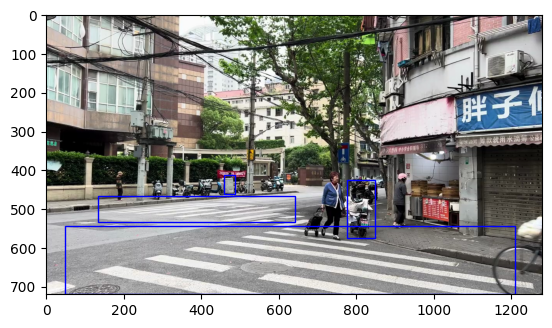

In [48]:
city = "shanghai"

CITY_IMGS = os.path.join(CWD,"resources","city","preprocessed","images",city)
CITY_LABELS = os.path.join(CWD,"resources","city","preprocessed","labels",city)
city_imgs_list = sorted(os.listdir(CITY_IMGS))
city_labels_list = sorted(os.listdir(CITY_LABELS))

img_num = 0
img = cv.imread(str(os.path.join(CITY_IMGS,city_imgs_list[img_num])))
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
im_h,im_w = img.shape[:2]

#print(city_imgs_list)

label_path = os.path.join(CITY_LABELS,city_labels_list[img_num])
with open(label_path, "r") as f:
    fig, ax = plt.subplots()
    for line in f:  
        print(line)
        class_id, x_center, y_center, w, h = map(float, line.split())
        yolo_box = [x_center, y_center, w, h]
        pt1,pt2 = yolo_to_bbox(yolo_box, im_w, im_h)
        ax.imshow(img)
        draw_box_on_axes(ax,pt1,pt2)
    plt.savefig("boxes_output.png")
    plt.show()

## Model Training and Creation

basically we hella fucked up and are not supposed to use some tensorflow cnn or anything but actually YOLO or like an object detection model

Idea is to isolate the objects inside train_images test_images and their respective object categories
given variables: train_images, train_labels, test_images, test_labels
turn them into:
    train_objects
        -stream of objects from all the images (all compiled together in one big arr)
        -all standardized at some 

#dont need
def get_iso_object_images(img, objs):
    """
    Cuts each object in the list from the image and returns a list of the objects
    :param img: og image where objects originate from
    :param objs: list of coordinates representing the objects
    :return: list of cut objects
    """
    cut_imgs = []
    for ob in objs:
        pt1,pt2 = get_box_from_object(ob)
        pt1 = tuple(int(i) for i in pt1)
        pt2 = tuple(int(i) for i in pt2)
        cut = np.copy(img)
        cut_imgs.append(cut[pt1[1]:pt2[1],pt1[0]:pt2[0]])
    return cut_imgs

time complexity is bad for this

In [49]:
def copy_to_final(from_dir,from_paths,data_dom,data_form):
    '''
    copy to final yolo folder
    :param from_dir: source of media
    :param from_paths: list of media being copied
    :param data_dom: "train" | "val"
    :param data_form: "images" | "labels"
    :return: 
    '''
    to_file = os.path.join(CWD,"resources",DATA_DIR,data_dom,data_form)
    if not os.path.exists(to_file):
        os.makedirs(to_file)
        
    for i in range(len(from_paths)):
        from_file = os.path.join(from_dir, from_paths[i])
        shutil.copy(from_file,to_file)

In [50]:
# collect and partition preprocessed manually labeled data
cities = ["la_lower", "shanghai"]

for cit in cities:
    pre_imgs_path = os.path.join(CWD,"resources","city","preprocessed","images", cit)
    pre_labels_path = os.path.join(CWD,"resources","city","preprocessed","labels", cit)
    
    pre_imgs = sorted(os.listdir(pre_imgs_path))
    pre_labels = sorted(os.listdir(pre_labels_path))
    
    #get total and partition 3:1
    total = len(pre_imgs)
    
    #these are all filenames btw!!
    fin_train_imgs = []
    fin_test_imgs = []
    fin_train_labels = []
    fin_test_labels = []
    
    for i in range(total):
        if i%4==1:
            fin_test_imgs.append(pre_imgs[i])
            fin_test_labels.append(pre_labels[i])
        else:
            fin_train_imgs.append(pre_imgs[i])
            fin_train_labels.append(pre_labels[i])
    
    # move files
    copy_to_final(pre_imgs_path,fin_train_imgs,"train","images")
    copy_to_final(pre_imgs_path,fin_test_imgs,"val","images")
    copy_to_final(pre_labels_path,fin_train_labels,"train","labels")
    copy_to_final(pre_labels_path,fin_test_labels,"val","labels")

In [51]:
def compile_cats(labels):
    """
    Find the total # of categories and encode them
    :param labels: Labels under a set of data that have objects with categories needing to be compiled
    :return: Compiled list of cats extracted with [i][j]th item representing ith image's jth object's category
    """
    obj_cats = []
    for a in range(len(labels)):
        obj_cats.append([])
        ob_cats = get_objects(labels[a])
        obj_cats[a].extend([ob["category"] for ob in ob_cats])
    return obj_cats

#find total number of categories and encode them
#train_objects = []
train_cats = []
for i in range(len(train_images)):
    train_cats.append([])
    ob_cats = get_objects(train_labels[i])
    #obj_imgs = get_iso_object_images(train_images[i], objects)
    #train_objects.extend(obj_imgs)
    train_cats[i].extend([ob["category"] for ob in ob_cats])

now that we have working objects and labels finalize data format
encode object categories

In [52]:
def encode_cats(all_raw_cats, manual_cats):
    """
    Encode cats into numbers from a list of raw cats
    :param all_raw_cats: list of each dataset each with their own raw cats 
    :return: encoded list of each image's respective enc cats + encoding used
    """
    cats = manual_cats
    all_cats_encoded = []
    for a in range(len(all_raw_cats)):
        all_cats_encoded.append([])
        curr_raw_cat = all_raw_cats[a]
        for b in range(len(curr_raw_cat)):
            all_cats_encoded[a].append([])
            for ob_cat in curr_raw_cat[b]:
                if ob_cat not in cats:
                    cats[ob_cat]=len(cats)
                all_cats_encoded[a][b].append(cats[ob_cat])
    return cats,all_cats_encoded

In [53]:
# get cats from manual labeled data
# include overlaps together

manual_cats_file = os.path.join(CWD,"resources","city","raw-labels","la_lower","obj.names")
manual_cats_key = {}
with open(manual_cats_file,"r") as f:
    ind = 0
    for line in f:
        processed_line = line.strip()
        manual_cats_key[processed_line]=ind
        ind+=1

In [54]:
train_cats = compile_cats(train_labels)
test_cats = compile_cats(test_labels)

raw_cats_data = [train_cats,test_cats]
cats_key, all_cats_enc = encode_cats(raw_cats_data,manual_cats_key)

In [55]:
def convert_pts_to_yolo(p1,p2,img_width,img_height):
    x1,y1=p1
    x2,y2=p2
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

def write_text_from_data(ind,img,label,cats_enc,directory):
    """
    Given image and label, find image and object and its objects and create an entry for each that names its category along with data about its bounding box, write to a new file for the image that the objects came from. Use the key and encoded categories to help encode entries.
    """
    filename = label["name"]+".txt"
    
    objects = get_objects(label)

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(os.path.join(directory,filename),"w") as f:
        for a in range(len(objects)):
            pt1, pt2 = get_box_from_object(objects[a])
            img_h,img_w = img.shape[:2]
            xc,yc,w,h = convert_pts_to_yolo(pt1,pt2,img_w,img_h)
            #write file
            f.write(f"{cats_enc[ind][a]} {xc} {yc} {w} {h}\n")

#test the encoding of categories
print(cats)

In [56]:
for i in range(len(train_images)):
    write_text_from_data(i, train_images[i], train_labels[i], all_cats_enc[0], ENCLABELS_TRAIN)
for i in range(len(test_images)):
    write_text_from_data(i, test_images[i], test_labels[i], all_cats_enc[1], ENCLABELS_TEST)

In [57]:
#train_images_paths
#test_images_paths
train_enclabels_paths = sorted(os.listdir(ENCLABELS_TRAIN))
test_enclabels_paths = sorted(os.listdir(ENCLABELS_TEST))


copy_to_final(IMAGES_TRAIN,train_images_paths,"train","images")
copy_to_final(IMAGES_TEST,test_images_paths,"val","images")
copy_to_final(ENCLABELS_TRAIN,train_enclabels_paths,"train","labels")
copy_to_final(ENCLABELS_TEST,test_enclabels_paths,"val","labels")

In [58]:
#testing file structure validity
final_train_images = sorted(os.listdir(str(os.path.join(CWD,"resources",DATA_DIR,"train","images"))))
final_train_labels = sorted(os.listdir(str(os.path.join(CWD,"resources",DATA_DIR,"train","labels"))))
final_test_images = sorted(os.listdir(str(os.path.join(CWD,"resources",DATA_DIR,"val","images"))))
final_test_labels = sorted(os.listdir(str(os.path.join(CWD,"resources",DATA_DIR,"val","labels"))))

for i in range(len(final_train_images)):
    if final_train_images[i][:-4] != final_train_labels[i][:-4]:
        print(i,final_train_images[i],final_train_labels[i])

print("\n\n")

for i in range(len(final_test_images)):
    if final_test_images[i][:-4] != final_test_labels[i][:-4]:
        print(i,final_test_images[i],final_test_labels[i])

In [59]:
iter_ind = 0
while iter_ind < len(train_labels_paths) and iter_ind<len(train_images_paths):
    if train_labels_paths[iter_ind][:-5]!=train_images_paths[iter_ind][:-4]:
        print(iter_ind)
    iter_ind+=1

In [61]:
offs = -1
pt = 552
print(train_images_paths[pt-offs-1],train_labels_paths[pt-offs-1])
print(train_images_paths[pt-offs],train_labels_paths[pt-offs])
print(train_images_paths[pt-offs+1],train_labels_paths[pt-offs+1])

18c4d009-fbd1c391.jpg 18c4d009-fbd1c391.json
18ca8efa-4f73df88.jpg 18ca8efa-4f73df88.json
18cb3c90-119d0711.jpg 18cb3c90-119d0711.json


In [62]:
#testing data makeup
makeups = {str(v):0 for k,v in cats_key.items()}
for i in range(len(final_train_labels)):
    with open(os.path.join(CWD,"resources",DATA_DIR,"train","labels",final_train_labels[i]), "r") as f:
        for line in f:
            cat = str(line.split(" ")[0])
            makeups[cat]+=1
print(makeups)

{'0': 0, '1': 993, '2': 660, '3': 0, '4': 2367, '5': 2868, '6': 16176, '7': 1082, '8': 1095, '9': 76, '10': 430, '11': 158, '12': 5}


In [63]:
data_yaml = {
    'path': os.path.join(CWD,"resources",DATA_DIR),
    'train': os.path.join(CWD,"resources",DATA_DIR,"train"),
    'val': os.path.join(CWD,"resources",DATA_DIR,"val"),
    'names': {str(v):k for k,v in cats_key.items()}
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [148]:
#for google
data_yaml = {
    'path': os.path.join("/content","drive","MyDrive","00 service-eye_resources"),
    'train': os.path.join("/content","drive","MyDrive","00 service-eye_resources","train"),
    'val': os.path.join("/content","drive","MyDrive","00 service-eye_resources","val"),
    'names': {str(v):k for k,v in cats_key.items()}
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
model = YOLO("yolov8n.pt")  # or yolov8n.pt
model.train(data="data.yaml", epochs=10, imgsz=384, batch=8, device="mps")

#results = model.predict(source="myimg.jpg", save=True, imgsz=640)

In [97]:
results = model.predict(source=0, show=True)


1/1: 0... Success ✅ (inf frames of shape 1920x1080 at 30.00 FPS)

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 224x384 (no detections), 11929.6ms
0: 224x384 (no detections), 238.0ms
0: 224x384 (no detections), 11.5ms
0: 224x384 (no detections), 15.8ms
0: 224x384 (no detections), 32.4ms
0: 224x384 (no detections), 9.3ms
0: 224x384 (no detections), 10.3ms
0: 224x384 (no detections), 10.6ms
0: 224x384 (no detections), 8.7ms
0: 224x384 (no detections), 11.0ms
0: 224x384 (no detections), 8.5ms
0: 2

In [7]:
model = YOLO(os.path.join(CWD,"resources","runs","detect","train","weights","last.pt"))  # use yolov5s.pt if you're using YOLOv5

# Use 0 for webcam, or "video.mp4" for a file
video_path = os.path.join(CWD,"resources","city","video","testing","boston_lower.mp4")

# Predict with stream=True yields a generator of results per frame
results_generator = model(video_path, stream=True)

# Loop through each result (per frame)
for result in results_generator:
    # You can access the original frame with result.orig_img
    # And the plotted detections with result.plot()
    frame = result.plot()

    # Display in OpenCV window
    cv.imshow("YOLO Stream", frame)

    # Break on 'q' or ESC
    key = cv.waitKey(1)
    if key == ord('q') or key == 27:
        break

cv.destroyAllWindows()


video 1/1 (frame 1/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 43.7ms
video 1/1 (frame 2/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 45.1ms
video 1/1 (frame 3/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 50.0ms
video 1/1 (frame 4/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 55.0ms
video 1/1 (frame 5/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 43.9ms
video 1/1 (frame 6/82732) /Users/mzhang/Documents/0b cs projects/service-eye/resources/city/video/testing/boston_lower.mp4: 384x640 (no detections), 43.4ms
video 1/1 (frame 7/82732) /Users/mzhang/Documents/0b cs project

In [13]:
model = YOLO("./runs/detect/train3/weights/best.pt")  # or yolov8n.pt
results = model.predict(source=2, show=True)

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train3/weights/best.pt'

## Tensorflow stuff that is bad
dont need ts damn

In [42]:
#tf model
model = tf.keras.Sequential([
    tf.keras.layers.Input((None, None, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [43]:
#model compilation and tf loss funct
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#run training
model.fit(train_objects, train_cats_enc, epochs=10)

In [ ]:
#run loss function
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)